In [1]:
# Standard library imports
import glob
import pickle


# Third party imports
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import ase
from sklearn.model_selection import KFold

# Local imports
from dataprocess import get_all_elements, read_csv,get_all_data,set_device_for_dataprocess
from stratified_sampler import StratifiedFixedSampler

# Set device
device = torch.device('cpu') # 'cuda' or 'cpu'
set_device_for_dataprocess(device)
print(f"Using device: {device}")


/home/baizh/soft/miniforge3/envs/mybase/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## Data Process and save the data and indices of train and test datset

In [37]:
origin_molecule_list = read_csv('../Delaney100_763_Converged_HF_STO3G/Delaney100_763_Converged_HF_STO3G.csv')
atom_list = read_csv('../Delaney100_763_Converged_HF_STO3G/Atoms.csv')


Processing molecules: 100%|██████████| 19/19 [00:00<00:00, 12187.15it/s]


In [38]:
#bin_num=100
#force_bins = np.linspace(0,0.03,bin_num)
#molecule_list = stratified_sampling_by_force(origin_molecule_list, force_bins, mode='uniform',n_sample=2)
#print('number of molecules after stratified sampling:',len(molecule_list))
#print('number of atoms after stratified sampling:',sum([len(mol['elements']) for mol in molecule_list]))
from copy import deepcopy
molecule_list = deepcopy(origin_molecule_list)
element_energy_dict = {}
for atom in atom_list:
    element = atom['elements'][0]
    energy = atom['energy']
    if element not in element_energy_dict:
        element_energy_dict[element] = energy

for mol in molecule_list:
    elements = mol['elements']
    energy_of_isolated_atoms = sum([element_energy_dict[element] for element in elements])
    mol['energy'] -= energy_of_isolated_atoms
    
    


In [40]:
mode='cross-validation' # 'holdout' or 'cross-validation'

dataset_size = len(molecule_list)
allelements=get_all_elements(molecule_list)

if mode == 'holdout':
    # Simple train-test split
    train_size = int(0.9 * dataset_size)
    test_size = dataset_size - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(
        molecule_list, 
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    
    print(f"Training set size: {len(train_dataset)}")
    print(f"Test set size: {len(test_dataset)}")
    train_indices = train_dataset.indices
    test_indices = test_dataset.indices

    torch.save(train_indices, 'bondenergy_train_indices.pt')
    torch.save(test_indices, 'bondenergy_test_indices.pt')
    
elif mode == 'cross-validation':
    # K-fold cross-validation setup
    k_folds = 10
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Save indices for each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(molecule_list)):
        train_idx=[int(i) for i in train_idx]
        test_idx=[int(i) for i in test_idx]
        print(f"Fold {fold+1}: Training set size: {len(train_idx)}, Test set size: {len(test_idx)}")
        torch.save(train_idx, f'bondenergy_train_indices_fold{fold+1}.pt')
        torch.save(test_idx, f'bondenergy_test_indices_fold{fold+1}.pt')
# Save the molecule list regardless of the mode
pickle.dump(molecule_list, open('bondenergy_molecule_list_cust.pkl', 'wb'))


Fold 1: Training set size: 686, Test set size: 77
Fold 2: Training set size: 686, Test set size: 77
Fold 3: Training set size: 686, Test set size: 77
Fold 4: Training set size: 687, Test set size: 76
Fold 5: Training set size: 687, Test set size: 76
Fold 6: Training set size: 687, Test set size: 76
Fold 7: Training set size: 687, Test set size: 76
Fold 8: Training set size: 687, Test set size: 76
Fold 9: Training set size: 687, Test set size: 76
Fold 10: Training set size: 687, Test set size: 76


## Read the data and indices of train and test datset

In [2]:
train_indices = torch.load('bondenergy_train_indices.pt') 
test_indices = torch.load('bondenergy_test_indices.pt')
molecule_list = pickle.load(open('bondenergy_molecule_list_cust.pkl', 'rb'))

train_dataset = torch.utils.data.Subset(molecule_list, train_indices)
test_dataset = torch.utils.data.Subset(molecule_list, test_indices)
allelements=get_all_elements(molecule_list)


In [3]:
# Calculate total energy and forces for all molecules
all_energies_per_atom = []
all_forces = []

for molecule in molecule_list:
    num_atom = len(molecule['elements'])
    all_energies_per_atom.append(molecule['energy']/num_atom)
    all_forces.append(molecule['forces'])

# Convert to numpy arrays
all_energies_per_atom = np.array(all_energies_per_atom)
all_forces = np.concatenate(all_forces, axis=0)

# Calculate mean values
mean_all_energy_per_atom = np.mean(all_energies_per_atom)
mean_force = np.mean(all_forces)

# Calculate RMSE values
rmse_all_energy_per_atom = np.sqrt(np.mean((all_energies_per_atom - mean_all_energy_per_atom)**2))
rmse_all_force = np.sqrt(np.mean((all_forces - mean_force)**2))

print(f"Mean energy per atom: {mean_all_energy_per_atom:.4e}")
print(f"Mean force: {mean_force:.4e}")
print(f"Root mean square energy per atom: {rmse_all_energy_per_atom:.4e}")
print(f"Root mean square force: {rmse_all_force:.4e}")
print(f"number of all molecules: {len(molecule_list)}")
print(f"number of all atoms: {len(all_forces)}")


Mean energy per atom: -1.9020e-01
Mean force: -7.6874e-13
Root mean square energy per atom: 1.4922e-02
Root mean square force: 1.5768e-05
number of all molecules: 763
number of all atoms: 25583


## Dataset distribution

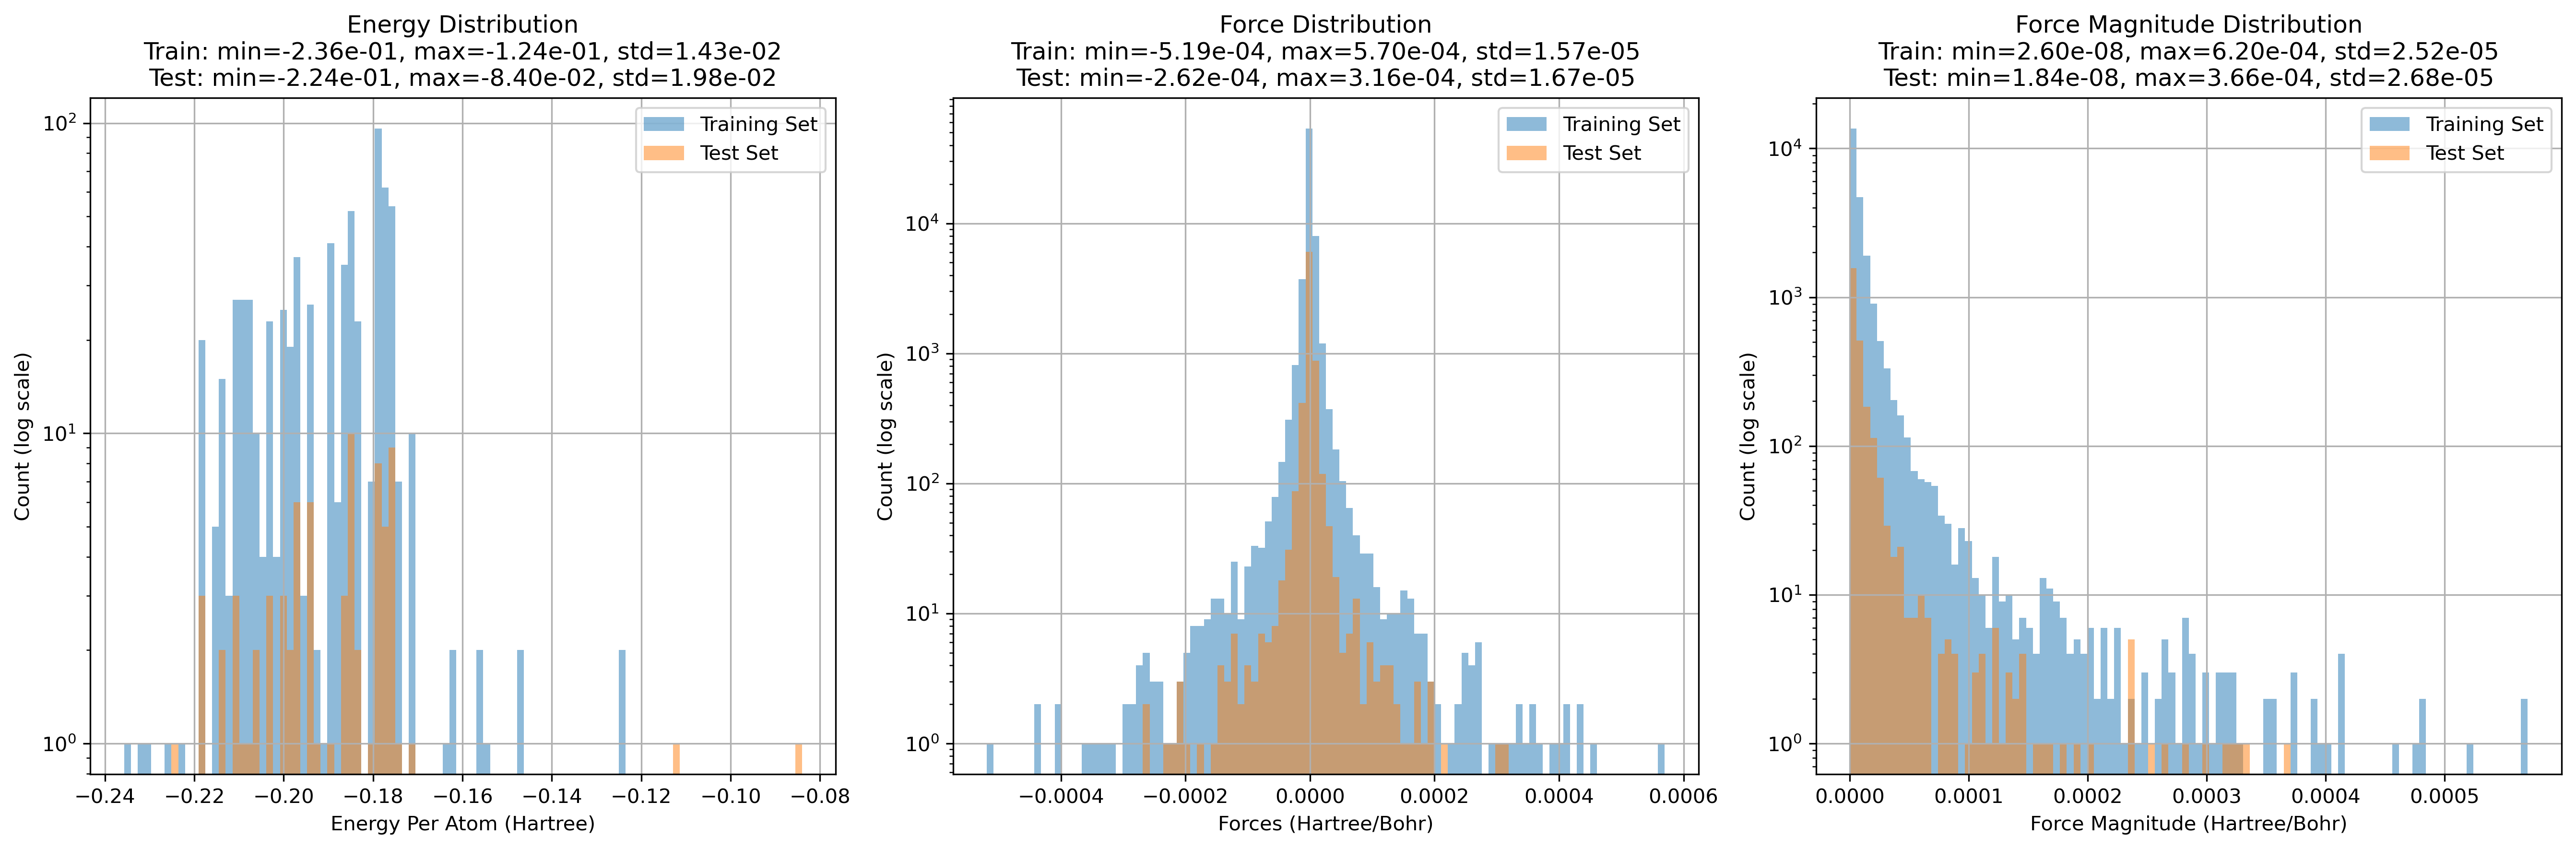

Training set energy per atom	 min -2.3574e-01 max -1.2409e-01 std 1.4255e-02:
Test set energy per atom	 min -2.2398e-01 max -8.4031e-02 std 1.9813e-02:
Training set force component	 min -5.1874e-04 max 5.6986e-04 std 1.5664e-05:
Test set force component	 min -2.6157e-04 max 3.1582e-04 std 1.6660e-05:
Training set force magnitude	 min 2.5962e-08 max 6.2008e-04 std 2.5176e-05:
Test set force magnitude	 min 1.8439e-08 max 3.6608e-04 std 2.6825e-05:


In [5]:
train_true_energies_per_atom, train_pred_energies_per_atom, test_true_energies_per_atom, test_pred_energies_per_atom,\
        train_true_forces, train_pred_forces, test_true_forces, test_pred_forces,\
        train_true_force_magnitude, train_pred_force_magnitude, test_true_force_magnitude, test_pred_force_magnitude=\
            get_all_data(model=None,train_dataset=train_dataset,test_dataset=test_dataset)

# Plot energy and force distributions
plt.figure(figsize=(18, 6),dpi=300)

# Plot energy distribution
plt.subplot(1, 3, 1)
energy_range = (min(min(train_true_energies_per_atom),min(test_true_energies_per_atom)), max(max(train_true_energies_per_atom),max(test_true_energies_per_atom)))
plt.hist(train_true_energies_per_atom, bins=100, alpha=0.5, label='Training Set', range=energy_range, log=True)
plt.hist(test_true_energies_per_atom, bins=100, alpha=0.5, label='Test Set', range=energy_range, log=True)
plt.xlabel('Energy Per Atom (Hartree)')
plt.ylabel('Count (log scale)')
plt.title('Energy Distribution\nTrain: min={:.2e}, max={:.2e}, std={:.2e}\nTest: min={:.2e}, max={:.2e}, std={:.2e}'.format(
    train_true_energies_per_atom.min(), train_true_energies_per_atom.max(), np.std(train_true_energies_per_atom),
    test_true_energies_per_atom.min(), test_true_energies_per_atom.max(), np.std(test_true_energies_per_atom)
))
plt.legend()
plt.grid(True)


# Plot force distribution train_true_forces
force_range = (min(min(train_true_forces),min(test_true_forces)), max(max(train_true_forces),max(test_true_forces)))
plt.subplot(1, 3, 2)

plt.hist(train_true_forces, bins=100, alpha=0.5, label='Training Set', range=force_range, log=True)
plt.hist(test_true_forces, bins=100, alpha=0.5, label='Test Set', range=force_range, log=True)
plt.xlabel('Forces (Hartree/Bohr)')
plt.ylabel('Count (log scale)')
plt.title('Force Distribution\nTrain: min={:.2e}, max={:.2e}, std={:.2e}\nTest: min={:.2e}, max={:.2e}, std={:.2e}'.format(
    train_true_forces.min(), train_true_forces.max(), np.std(train_true_forces),
    test_true_forces.min(), test_true_forces.max(), np.std(test_true_forces)
))
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.subplot(1, 3, 3)
plt.hist(train_true_force_magnitude, bins=100, alpha=0.5, label='Training Set', range=(0,force_range[1]), log=True)
plt.hist(test_true_force_magnitude, bins=100, alpha=0.5, label='Test Set', range=(0,force_range[1]), log=True)
plt.xlabel('Force Magnitude (Hartree/Bohr)')
plt.ylabel('Count (log scale)')
plt.title('Force Magnitude Distribution\nTrain: min={:.2e}, max={:.2e}, std={:.2e}\nTest: min={:.2e}, max={:.2e}, std={:.2e}'.format(
    train_true_force_magnitude.min(), train_true_force_magnitude.max(), np.std(train_true_force_magnitude),
    test_true_force_magnitude.min(), test_true_force_magnitude.max(), np.std(test_true_force_magnitude)
))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print('Training set energy per atom\t min {:.4e} max {:.4e} std {:.4e}:'.format(train_true_energies_per_atom.min(), train_true_energies_per_atom.max(), np.std(train_true_energies_per_atom))  )
print('Test set energy per atom\t min {:.4e} max {:.4e} std {:.4e}:'.format(test_true_energies_per_atom.min(), test_true_energies_per_atom.max(), np.std(test_true_energies_per_atom)))
print('Training set force component\t min {:.4e} max {:.4e} std {:.4e}:'.format(train_true_forces.min(), train_true_forces.max(), np.std(train_true_forces)))
print('Test set force component\t min {:.4e} max {:.4e} std {:.4e}:'.format(test_true_forces.min(), test_true_forces.max(), np.std(test_true_forces)))
print('Training set force magnitude\t min {:.4e} max {:.4e} std {:.4e}:'.format(train_true_force_magnitude.min(), train_true_force_magnitude.max(), np.std(train_true_force_magnitude)))
print('Test set force magnitude\t min {:.4e} max {:.4e} std {:.4e}:'.format(test_true_force_magnitude.min(), test_true_force_magnitude.max(), np.std(test_true_force_magnitude)))


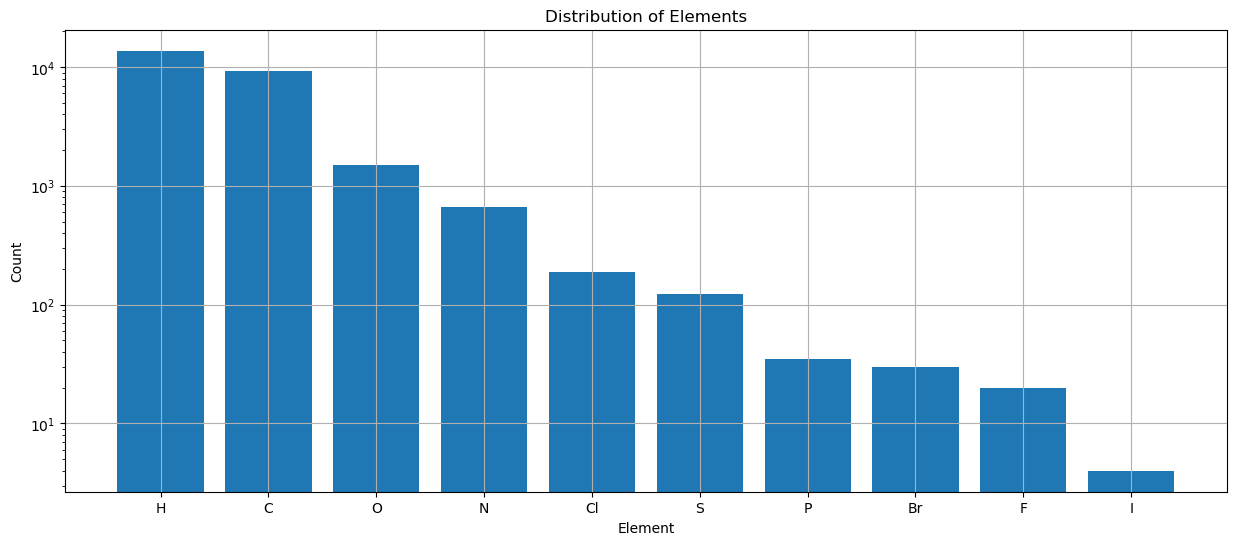

In [9]:
# Calculate and plot element distribution from molecule_list
element_symbols=[]
# Count elements from molecule_list
for molecule in molecule_list:
    element_symbols.extend(ase.data.chemical_symbols[atom] for atom in molecule['elements'])
element_counts = {}
for element_symbol in element_symbols:
    if element_symbol in element_counts:
        element_counts[element_symbol] += 1
    else:
            element_counts[element_symbol] = 1

# Convert to Series for easier plotting
element_counts = pd.Series(element_counts)
element_counts = element_counts.sort_values(ascending=False)  # Sort by count instead of index

plt.figure(figsize=(15, 6))
plt.bar(element_counts.index, element_counts.values)
plt.xlabel('Element')
plt.ylabel('Count')
plt.title('Distribution of Elements')
plt.grid(True)
plt.yscale('log')
plt.show()


## Test for sampler used on training set

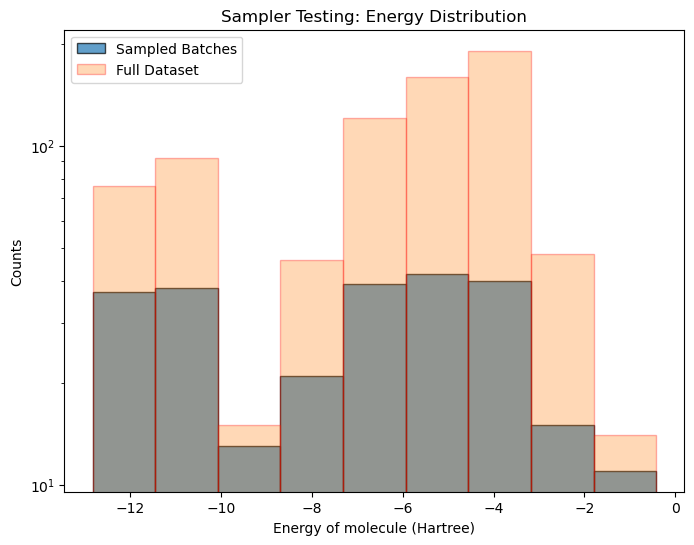

In [8]:
def test_sampler(sampler, energies, bins, n_batches=100):
    """
    sampler: Your StratifiedFixedSampler
    energies: Original list of energies
    bins: List of energy bins
    n_batches: Number of batches to test (e.g., 100)
    """

    sampled_energies = []

    # Randomly sample n_batches batches
    iterator = iter(sampler)
    for _ in range(n_batches):
        batch_indices = [next(iterator) for _ in range(min(sampler.batch_size,len(energies)))]
        batch_energies = [energies[idx] for idx in batch_indices]
        sampled_energies.extend(batch_energies)

    sampled_energies = np.array(sampled_energies)

    # Plot histogram
    plt.figure(figsize=(8,6))
    plt.hist(sampled_energies, bins=bins, edgecolor='black', alpha=0.7, label='Sampled Batches')
    plt.hist(energies, bins=bins, edgecolor='red', alpha=0.3, label='Full Dataset')
    plt.xlabel('Energy of molecule (Hartree)')
    plt.ylabel('Counts')
    plt.legend()
    plt.title('Sampler Testing: Energy Distribution')
    plt.yscale('log')
    plt.show()
energies = [molecule['energy'] for molecule in molecule_list]
bins = np.linspace(min(energies), max(energies), 10)
sampler = StratifiedFixedSampler(energies, 256, bins)
test_sampler(
    sampler=sampler,
    energies=energies,  # your training set energy list
    bins=bins,
    n_batches=1  # check the effect with 5 batches
)

## Loss analysis

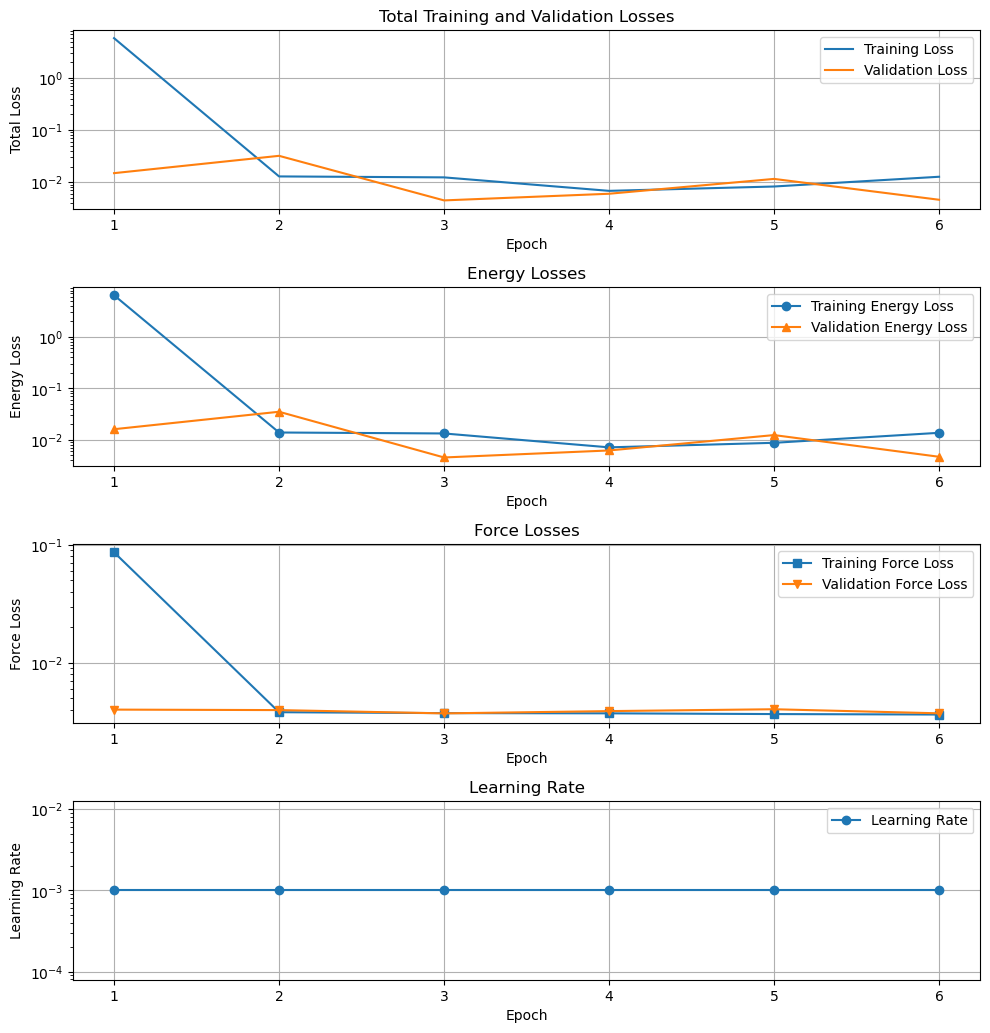

In [7]:
files=glob.glob('losses_epoch_*.pt')
train_losses=[]
train_energy_losses=[]
train_force_losses=[]
val_losses=[]
val_energy_losses=[]
val_force_losses=[]
learning_rates=[]
epochs=[]
for file in files:
    epoch=torch.load(file)['epoch']
    train_loss=torch.load(file)['train_loss']
    train_energy_loss=torch.load(file)['train_energy_loss']
    train_force_loss=torch.load(file)['train_force_loss']
    val_loss=torch.load(file)['val_loss']
    val_energy_loss=torch.load(file)['val_energy_loss']
    val_force_loss=torch.load(file)['val_force_loss']
    learning_rate=torch.load(file)['lr']
    train_losses.append(train_loss)
    train_energy_losses.append(train_energy_loss)
    train_force_losses.append(train_force_loss)
    val_losses.append(val_loss)
    val_energy_losses.append(val_energy_loss)
    val_force_losses.append(val_force_loss)
    learning_rates.append(learning_rate)
    epochs.append(epoch)
    
# Sort by epoch number
sorted_indices = sorted(range(len(epochs)), key=lambda k: epochs[k])

epochs = [epochs[i] for i in sorted_indices]
train_losses = [train_losses[i] for i in sorted_indices]
train_energy_losses = [train_energy_losses[i] for i in sorted_indices]
train_force_losses = [train_force_losses[i] for i in sorted_indices]
val_losses = [val_losses[i] for i in sorted_indices]
val_energy_losses = [val_energy_losses[i] for i in sorted_indices]
val_force_losses = [val_force_losses[i] for i in sorted_indices]
learning_rates = [learning_rates[i] for i in sorted_indices]
plt.figure(figsize=(10,10))

# Plot total losses
plt.subplot( 4,1, 1)
plt.plot(epochs,train_losses, label='Training Loss')
plt.plot(epochs,val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.yscale('log')

#Plot energy and force losses
# Create a figure with two subplots for energy and force losses

# Plot energy losses
plt.subplot(4,1, 2)
plt.plot(epochs, train_energy_losses, 'o-', label='Training Energy Loss')
plt.plot(epochs, val_energy_losses, '^-', label='Validation Energy Loss')
plt.xlabel('Epoch')
plt.ylabel('Energy Loss')
plt.title('Energy Losses')
plt.legend()
plt.grid(True)
plt.yscale('log')

# Plot force losses
plt.subplot(4,1, 3)
plt.plot(epochs, train_force_losses, 's-', label='Training Force Loss')
plt.plot(epochs, val_force_losses, 'v-', label='Validation Force Loss')
plt.xlabel('Epoch')
plt.ylabel('Force Loss')
plt.title('Force Losses')
plt.legend()
plt.grid(True)
plt.yscale('log')

plt.tight_layout()


plt.subplot(4,1, 4)
plt.plot(epochs, learning_rates, 'o-', label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

## Prediction analysis

In [8]:

from model import load_model,get_the_checkpoint_path_of_latest_epoch
from train_it import empty_model
last_checkpoint,last_epoch=get_the_checkpoint_path_of_latest_epoch()
model=load_model(empty_model,last_checkpoint)

train_true_energies_per_atom, train_pred_energies_per_atom, test_true_energies_per_atom, test_pred_energies_per_atom,\
        train_true_forces, train_pred_forces, test_true_forces, test_pred_forces,\
        train_true_force_magnitude, train_pred_force_magnitude, test_true_force_magnitude, test_pred_force_magnitude=\
            get_all_data(model=model,train_dataset=train_dataset,test_dataset=test_dataset)
# Calculate RMSE metrics
train_rmse_e_per_atom = np.sqrt(np.mean((train_true_energies_per_atom - train_pred_energies_per_atom)**2))
test_rmse_e_per_atom = np.sqrt(np.mean((test_true_energies_per_atom - test_pred_energies_per_atom)**2))
train_rmse_f = np.sqrt(np.mean((train_true_forces - train_pred_forces)**2))
test_rmse_f = np.sqrt(np.mean((test_true_forces - test_pred_forces)**2))


# Plot results
plt.figure(figsize=(14, 21))

# Plot training energies
plt.subplot(3, 2, 1)
plt.scatter(train_true_energies_per_atom, train_pred_energies_per_atom, 
           label=f'Training Set (RMSE: {train_rmse_e_per_atom:.3f} Hartree)', alpha=0.5)

min_e = min(np.min(train_true_energies_per_atom), np.max(train_true_energies_per_atom))
max_e = max(np.min(train_true_energies_per_atom), np.max(train_true_energies_per_atom))
plt.plot([min_e, max_e], [min_e, max_e], 'k--', label='y=x')

plt.xlabel('True Energy Per Atom (Hartree)')
plt.ylabel('Predicted Energy Per Atom (Hartree)') 
plt.title('Training Set: Predicted vs True Energies')
plt.legend()
plt.grid(True)

# Plot test energies
plt.subplot(3, 2, 2)
plt.scatter(test_true_energies_per_atom, test_pred_energies_per_atom,
           label=f'Test Set (RMSE: {test_rmse_e_per_atom:.3f} Hartree)', alpha=0.5)

min_e = min(np.min(test_true_energies_per_atom), np.max(test_true_energies_per_atom))
max_e = max(np.min(test_true_energies_per_atom), np.max(test_true_energies_per_atom))
plt.plot([min_e, max_e], [min_e, max_e], 'k--', label='y=x')

plt.xlabel('True Energy Per Atom (Hartree)')
plt.ylabel('Predicted Energy Per Atom (Hartree)')
plt.title('Test Set: Predicted vs True Energies') 
plt.legend()
plt.grid(True)

# Plot training forces
plt.subplot(3, 2, 3)
plt.scatter(train_true_forces, train_pred_forces,
           label=f'Training Set (RMSE: {train_rmse_f:.3f} Hartree/Bohr)', alpha=0.5)

min_f = min(np.min(train_true_forces), np.max(train_true_forces))
max_f = max(np.min(train_true_forces), np.max(train_true_forces))
plt.plot([min_f, max_f], [min_f, max_f], 'k--', label='y=x')

plt.xlabel('True Force (Hartree/Bohr)')
plt.ylabel('Predicted Force (Hartree/Bohr)')
plt.title('Training Set: Predicted vs True Forces')
plt.legend()
plt.grid(True)

# Plot test forces
plt.subplot(3, 2, 4)
plt.scatter(test_true_forces, test_pred_forces,
           label=f'Test Set (RMSE: {test_rmse_f:.3f} Hartree/Bohr)', alpha=0.5)

min_f = min(np.min(test_true_forces), np.max(test_true_forces))
max_f = max(np.min(test_true_forces), np.max(test_true_forces))
plt.plot([min_f, max_f], [min_f, max_f], 'k--', label='y=x')

plt.xlabel('True Force (Hartree/Bohr)')
plt.ylabel('Predicted Force (Hartree/Bohr)')
plt.title('Test Set: Predicted vs True Forces')
plt.legend()
plt.grid(True)
# Plot training forces
plt.subplot(3, 2, 5)
plt.scatter(train_true_force_magnitude, train_pred_force_magnitude, alpha=0.5)

min_f = 0
max_f = max(np.min(train_true_force_magnitude), np.max(train_true_force_magnitude))
plt.plot([min_f, max_f], [min_f, max_f], 'k--', label='y=x')

plt.xlabel('True Force Mag. (Hartree/Bohr)')
plt.ylabel('Predicted Force Mag. (Hartree/Bohr)')
plt.title('Training Set: Predicted vs True Forces')
plt.legend()
plt.grid(True)

# Plot test forces
plt.subplot(3, 2, 6)
plt.scatter(test_true_force_magnitude, test_pred_force_magnitude, alpha=0.5)

min_f = 0
max_f = max(np.min(test_true_force_magnitude), np.max(test_true_force_magnitude))
plt.plot([min_f, max_f], [min_f, max_f], 'k--', label='y=x')

plt.xlabel('True Force Mag. (Hartree/Bohr)')
plt.ylabel('Predicted Force Mag. (Hartree/Bohr)')
plt.title('Test Set: Predicted vs True Forces')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

### Zoom in for force

In [ ]:
# Set figure size
plt.figure(figsize=(15, 10))
mag=0.03    
# Plot training forces
plt.subplot(2, 2, 1)
plt.scatter(train_true_forces, train_pred_forces,
           label=f'Training Set (RMSE for whole dataset: {train_rmse_f:.3f} Hartree/Bohr)', alpha=0.5)

plt.plot([-mag, mag], [-mag, mag], 'k--', label='y=x')
plt.xlim(-mag, mag)
plt.ylim(-mag, mag)


plt.xlabel('True Force (Hartree/Bohr)')
plt.ylabel('Predicted Force (Hartree/Bohr)')
plt.title('Training Set: Predicted vs True Forces')
plt.legend()
plt.grid(True)

# Plot test forces
plt.subplot(2, 2, 2)
plt.scatter(test_true_forces, test_pred_forces,
           label=f'Test Set (RMSE for whole dataset: {test_rmse_f:.3f} Hartree/Bohr)', alpha=0.5)

plt.plot([-mag, mag], [-mag, mag], 'k--', label='y=x')
plt.xlim(-mag, mag)
plt.ylim(-mag, mag)

plt.xlabel('True Force (Hartree/Bohr)')
plt.ylabel('Predicted Force (Hartree/Bohr)')
plt.title('Test Set: Predicted vs True Forces')
plt.legend()
plt.grid(True)

# Plot training force mag
plt.subplot(2, 2, 3)
plt.scatter(train_true_force_magnitude, train_pred_force_magnitude, alpha=0.5)

plt.plot([-mag, mag], [-mag, mag], 'k--', label='y=x')
plt.xlim(0, mag)
plt.ylim(0, mag)


plt.xlabel('True Force (Hartree/Bohr)')
plt.ylabel('Predicted Force (Hartree/Bohr)')
plt.title('Training Set: Predicted vs True Forces')
plt.legend()
plt.grid(True)

# Plot test force mag
plt.subplot(2, 2, 4)
plt.scatter(test_true_force_magnitude, test_pred_force_magnitude, alpha=0.5)

plt.plot([-mag, mag], [-mag, mag], 'k--', label='y=x')
plt.xlim(0, mag)
plt.ylim(0, mag)

plt.xlabel('True Force (Hartree/Bohr)')
plt.ylabel('Predicted Force (Hartree/Bohr)')
plt.title('Test Set: Predicted vs True Forces')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Zoom in for energy

Number of training points in range: 96 out of 102
Number of test points in range: 11 out of 12


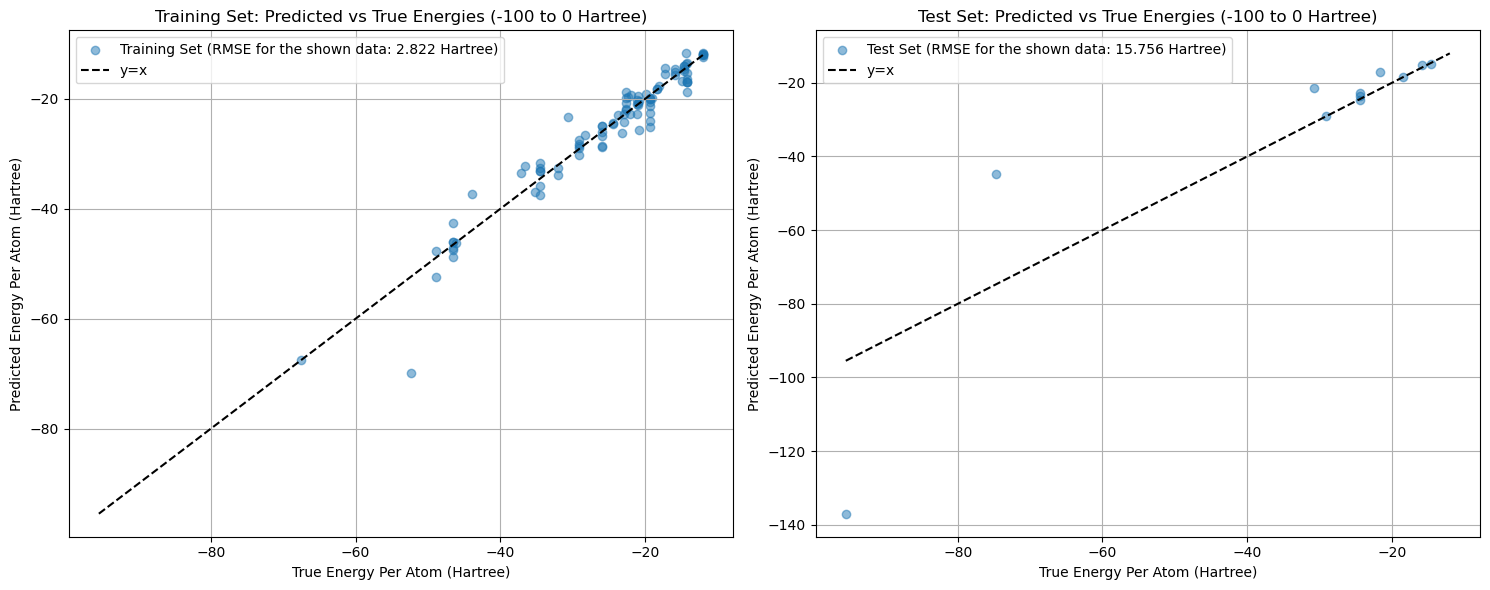

In [85]:
# Plot training set results with energy range -2000 to 0 Hartree
plt.figure(figsize=(15, 6))
low_limit=-100
high_limit=0
# Filter data points within the specified range
train_mask = (train_true_energies_per_atom >= low_limit) & (train_true_energies_per_atom <= high_limit)
test_mask = (test_true_energies_per_atom >= low_limit) & (test_true_energies_per_atom <= high_limit)
# Print number of data points after filtering
print(f"Number of training points in range: {np.sum(train_mask)} out of {len(train_true_energies_per_atom)}")
print(f"Number of test points in range: {np.sum(test_mask)} out of {len(test_true_energies_per_atom)}")

# Calculate RMSE for filtered data
train_rmse_e_filtered = np.sqrt(np.mean((train_true_energies_per_atom[train_mask] - train_pred_energies_per_atom[train_mask])**2))
test_rmse_e_filtered = np.sqrt(np.mean((test_true_energies_per_atom[test_mask] - test_pred_energies_per_atom[test_mask])**2))

# Plot training energies
plt.subplot(1, 2, 1)
plt.scatter(train_true_energies_per_atom[train_mask], train_pred_energies_per_atom[train_mask],
           label=f'Training Set (RMSE for the shown data: {train_rmse_e_filtered:.3f} Hartree)', alpha=0.5)

min_e = max(-2000, min(np.min(train_true_energies_per_atom[train_mask]), np.min(test_true_energies_per_atom[test_mask])))
max_e = min(0, max(np.max(train_true_energies_per_atom[train_mask]), np.max(test_true_energies_per_atom[test_mask])))
plt.plot([min_e, max_e], [min_e, max_e], 'k--', label='y=x')

plt.xlabel('True Energy Per Atom (Hartree)')
plt.ylabel('Predicted Energy Per Atom (Hartree)')
plt.title(f'Training Set: Predicted vs True Energies ({low_limit} to {high_limit} Hartree)')
plt.legend()
plt.grid(True)

# Plot test energies
plt.subplot(1, 2, 2)
plt.scatter(test_true_energies_per_atom[test_mask], test_pred_energies_per_atom[test_mask],
           label=f'Test Set (RMSE for the shown data: {test_rmse_e_filtered:.3f} Hartree)', alpha=0.5)

plt.plot([min_e, max_e], [min_e, max_e], 'k--', label='y=x')

plt.xlabel('True Energy Per Atom (Hartree)')
plt.ylabel('Predicted Energy Per Atom (Hartree)')
plt.title(f'Test Set: Predicted vs True Energies ({low_limit} to {high_limit} Hartree)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
